## Example 03 - Fuel Use

**Example description:** Example of estimating fuel use on a project.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [17]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

In [18]:
# Create simulation environment
simulation_start = datetime.datetime.now()

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions
    core.HasSpill - enables tracking of spill
    core.HasSpillCondition - enable imposition of spill limits
    core.HasSoil - enables book keeping of soil layers and soil information

#### First create objects with the desired properties

In [19]:
# The generic site class
Site = type('Site', (core.Identifiable, # Give it a name
                     core.Log,          # Allow logging of all discrete events
                     core.Locatable,    # Add coordinates to extract distance information and visualize
                     core.HasContainer, # Add information on the material available at the site
                     core.HasResource), # Add information on serving equipment
            {})                         # The dictionary is empty because the site type is generic

#### Next specify the properties for sites you wish to create

In [20]:
# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": location_from_site, # The coordinates of the project site
                  "capacity": 500_000,            # The capacity of the site
                  "level": 500_000}               # The actual volume of the site


# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)     # lon, lat

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": location_to_site,     # The coordinates of the project site
                "capacity": 500_000,              # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

#### Finally create specific instances of the predefined objects with the specified properties

In [21]:
# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site   = Site(**data_to_site)

sites = [from_site, to_site]

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - s moving container, so capacity and location
    core.Processor - allows for loading and unloading
    core.HasResource - adds information on serving equipment
    core.HasDepthRestriction - adds information on depth restriction 
    core.HasSoil - adds soil object, because it moves soil
    core.HasPlume - initializes spill terms

#### First create objects with the desired properties

In [22]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.EnergyUse),
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [23]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda x: x / rate

def compute_unloading(rate):
    return lambda x: x / rate

In [24]:
# Fuel use depends on vessel characteristics
def compute_energy_use_loading(variable_1, variable_2):
    # x could be the loaded volume, y could be the production rate
    # so x / y would be a unit of time
    return lambda x: x * (variable_1 * variable_2)

def compute_energy_use_unloading(variable_1, variable_2):
    # x could be the loaded volume, y could be the production rate
    # so x / y would be a unit of time
    return lambda x: x * (variable_1 * variable_2)

def compute_energy_use_sailing(variable_1, variable_2):
    # x could be the distance, y could be the sailing speed
    # so x / y would be a unit of time
    return lambda x: x * (variable_1 * variable_2)

#### Finally create specific instances of the predefined objects with the specified properties

In [25]:
# TSHD variables
data_hopper = {"env": my_env,                                                    # The simpy environment 
               "name": "Hopper 01",                                              # Name
               "geometry": location_from_site,                                   # It starts at the "from site"
               "loading_func": compute_loading(1.5),                             # Loading rate
               "unloading_func": compute_unloading(1.5),                         # Unloading rate
               "capacity": 5_000,                                                # Capacity of the hopper
               "compute_v": compute_v_provider(5, 4.5),                          # Variable speed 
               "energy_use_loading": compute_energy_use_loading(5_000, 1.0),     # Variable fuel use
               "energy_use_sailing": compute_energy_use_sailing(5_000, 0.5),     # Variable fuel use
               "energy_use_unloading": compute_energy_use_unloading(5_000, 1.0)} # Variable fuel use

In [26]:
# The simulation object
hopper = TransportProcessingResource(**data_hopper)

### 1.3 Define the activity

In [27]:
# Create activity
activity = model.Activity(env = my_env,           # The simpy environment defined in the first cel
                          name = "Soil movement", # We are moving soil
                          origin = from_site,     # We originate from the from_site
                          destination = to_site,  # And therefore travel to the to_site
                          loader = hopper,        # The benefit of a TSHD, all steps can be done
                          mover = hopper,         # The benefit of a TSHD, all steps can be done
                          unloader = hopper,      # The benefit of a TSHD, all steps can be done
                          start_condition = None) # We can start right away and do not stop

### 2. Run the simulation

In [28]:
my_env.run()

print("\n*** Installation of dike finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))

T=1549471888.00 Start condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie started
T=1550534750.51 Stop condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie complete

*** Installation of dike finished in 12 days, 7:14:22 ***


### 3. Postprocessing

#### Vessel planning

In [29]:
vessels = [hopper]

activities = ['loading', 'unloading', 'sailing full', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### Some results

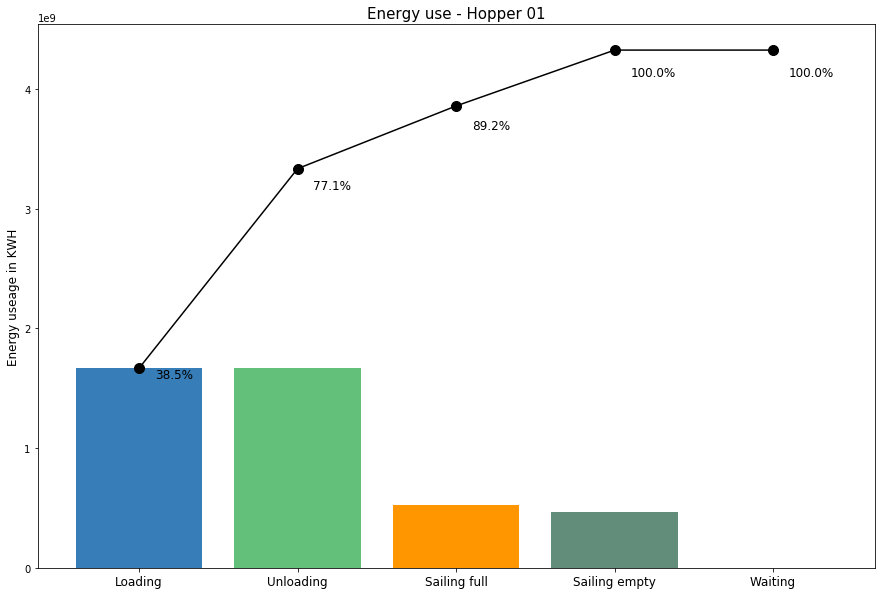

In [30]:
plot.energy_use(hopper)

#### KML visualisation

In [31]:
plot.vessel_kml(my_env, vessels, stepsize = 3600)
plot.site_kml(my_env, sites, stepsize = 3600)

In [32]:
# open the file
if platform.system():
    !start ./vessel_movements.kml
    !start ./site_development.kml
else:
    !start explorer ./vessel_movements.kml
    !start explorer ./site_development.kml